In [1]:
import numpy as np
import torch
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams['image.interpolation'] = 'bilinear'

from argparse import ArgumentParser

from torch.optim import SGD, Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor, ToPILImage
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import lr_scheduler
from networks.network_SegNet_bn_d import SegNet_bn_enc4

import collections
import numbers
import random
import math
from PIL import Image, ImageOps, ImageEnhance
import logging
import time
import tool

In [2]:
CROSS_VALIDATION_FOLD = 0 # 0-4
SEED = CROSS_VALIDATION_FOLD * 100

In [3]:
log_filename = 'train2_SegNet_bn_d-fold'+str(CROSS_VALIDATION_FOLD)+'.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s')
def log(message):
    print(message)
    logging.info(message)

In [4]:
log('='*50 + 'start run' + '='*50)

==================================================start run==================================================


## dataset

In [5]:
NUM_CHANNELS = 3
NUM_CLASSES = 2 # car is 1, background is 0

In [6]:
random_rotate = tool.Random_Rotate_Crop(maxAngle = 10)
crop = tool.Random_Rotate_Crop(maxAngle = 0)
crop_512 = tool.RandomCrop(crop_size = 512)
random_color = tool.RandomColor()
to_tensor_label = tool.ToTensor_Label()
normalize = tool.ImageNormalize([.485, .456, .406], [.229, .224, .225])
train_transforms = tool.Compose([random_rotate, crop_512, random_color, to_tensor_label, normalize])
val_transforms = tool.Compose([crop, crop_512, to_tensor_label, normalize])

In [7]:
image_path = '../data/images_flip/train/'
mask_path = '../data/images_flip/train_masks/'

In [8]:
with open('../data/train_shuffle_names.pk', 'rb') as f:
    filenames = pickle.load(f)

In [9]:
fold_num = len(filenames) // 5
folds = []
for i in range(5):
    if i == 4:
        folds.append(filenames[i * fold_num :])
    else:
        folds.append(filenames[i * fold_num : (i + 1) * fold_num])

train_filenames = []
for i in range(5):
    if i == CROSS_VALIDATION_FOLD:
        val_filenames = folds[i]
    else:
        train_filenames += folds[i]

In [10]:
train_set = tool.Car_dataset(image_path, mask_path, train_filenames, train_transforms) 
val_set = tool.Car_dataset(image_path, mask_path, val_filenames, val_transforms) # for validation set

In [11]:
train_loader = DataLoader(train_set, num_workers=4, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, num_workers=4, batch_size=1) # for validation set

## dataset examples

In [12]:
train_loader.batch_size

4

In [13]:
inp, tar = val_loader.__iter__().next()

In [14]:
i = 0
inp = Variable(inp)
tar = Variable(tar)
# tar[:, 0]
t = tar[i].cpu().data.numpy()
inpu = inp[i].cpu().data.numpy()

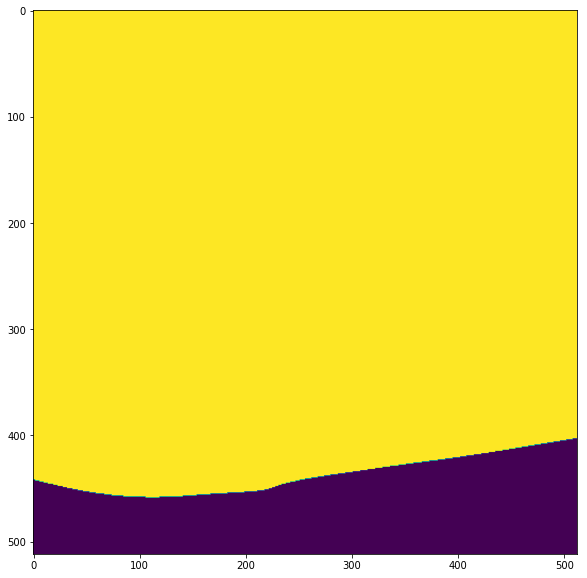

In [15]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(t[0])
# plt.imshow(inpu[0])

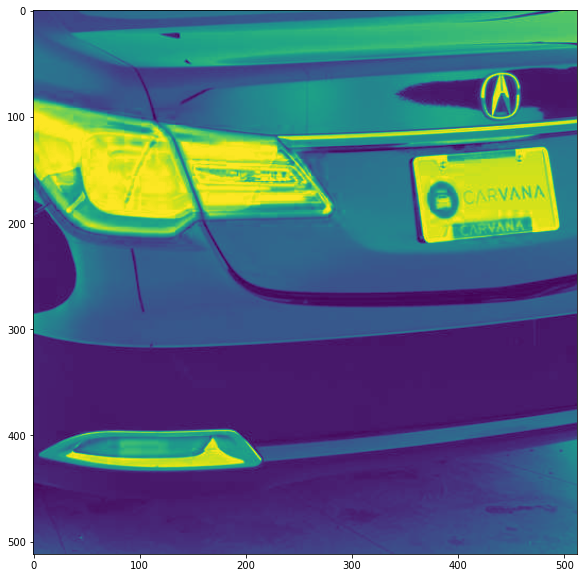

In [16]:
plt.imshow(inpu[0])

## model

In [17]:
model = SegNet_bn_enc4(NUM_CLASSES)
model = model.cuda()
# load the weights for the trained model
# model.load_state_dict(torch.load('models/SegNet_5-512.pth'))

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/yini/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [03:56<00:00, 2338693.65it/s]


## train define

In [ ]:
def train(epoch, steps_plot=0):
    model.train()

    weight = torch.ones(NUM_CLASSES)
#     weight[1] = 5 # weight of wall is 5

    criterion = CrossEntropyLoss2d(weight.cuda()) # loss function

    epoch_loss = []
    step_loss = []

    for step, (images, labels) in enumerate(train_loader):
        
        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        outputs = model(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, targets[:, 0])
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.data[0])
        step_loss.append(loss.data[0])
        
        if step % 10 == 0:
            average_step_loss = sum(step_loss) / len(step_loss)
            print('===> Epoch[{}]({}/{}): loss: {:.4}'.format(epoch, 
                                step, len(train_loader), average_step_loss))
            step_loss = []
    average = sum(epoch_loss) / len(epoch_loss)
    print('==================> train average loss: {:.4}'.format(average))
            

In [ ]:
def test(steps_plot = 0):
    model.eval()

    weight = torch.ones(NUM_CLASSES)
#     weight[1] = 5 # weight of wall is 5

    criterion = CrossEntropyLoss2d(weight.cuda())

#     for epoch in range(start_epoch, end_epochs+1):
    total_loss = []

    for step, (images, labels) in enumerate(val_loader):

        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        outputs = model(inputs)

        loss = criterion(outputs, targets[:, 0])

        total_loss.append(loss.data[0])

    average = sum(total_loss) / len(total_loss)
    print('========================>Validation: average_loss: {:.4}'.format( average))
    return average

## train


In [ ]:
save_name = 'SegNet_5_enc4'
loss_vallidation = []

In [ ]:
optimizer = Adam(model.parameters(), lr = 1e-3, weight_decay= 1e-9)
epoch_end = 50
for epoch in range(epoch_end):
    train(epoch)
    val_loss = test()
        
    if epoch % 5 == 0:
        save_file_name = 'models/'+save_name+'-'+'%.5f' % val_loss+'.pth'
        print 'save weights ' + '-'*30 + save_file_name
        torch.save(model.state_dict(), save_file_name)
        
    loss_vallidation.append(val_loss)

In [ ]:
save_file_name = 'models/'+save_name+'.pth'
print 'save weights ' + '-'*30 + save_file_name
torch.save(model.state_dict(), save_file_name)

In [ ]:
optimizer = Adam(model.parameters(), lr = 1e-3)
num = 50
epoch_start = epoch_end
epoch_end = epoch_start+num
for epoch in range(epoch_start, epoch_end):
    train(epoch)
    val_loss = test()
    
    if epoch % 5 == 0:
        save_file_name = 'models/'+save_name+'-'+'%.5f' % val_loss+'.pth'
        print 'save weights ' + '-'*30 + save_file_name
        torch.save(model.state_dict(), save_file_name)
    loss_vallidation.append(val_loss)

In [ ]:
save_file_name = 'models/'+save_name+'.pth'
print 'save weights ' + '-'*30 + save_file_name
torch.save(model.state_dict(), save_file_name)

In [ ]:

optimizer = Adam(model.parameters(), lr = 5e-4)
num = 36
epoch_start = 114
epoch_end = epoch_start+num
for epoch in range(epoch_start, epoch_end):
    train(epoch)
    val_loss = test()
    
    if (val_loss < np.array(loss_vallidation).min()) or (epoch % 5 == 0):
        save_file_name = 'models/'+save_name+'-'+'%.5f' % val_loss+'.pth'
        print 'save weights ' + '-'*30 + save_file_name
        torch.save(model.state_dict(), save_file_name)
    loss_vallidation.append(val_loss)

In [ ]:
np.array(np.array(loss_vallidation).min()).min()

In [ ]:
save_file_name = 'models/'+save_name+'.pth'
print 'save weights ' + '-'*30 + save_file_name
torch.save(model.state_dict(), save_file_name)

In [ ]:
optimizer = Adam(model.parameters(), lr = 1e-4)
num = 40
epoch_start = epoch_end
epoch_end = epoch_start+num
for epoch in range(epoch_start, epoch_end):
    train(epoch)
    val_loss = test()
    
    if (val_loss < np.array(loss_vallidation).min()) or (epoch % 5 == 0):
        save_file_name = 'models/'+save_name+'-'+'%.5f' % val_loss+'.pth'
        print 'save weights ' + '-'*30 + save_file_name
        torch.save(model.state_dict(), save_file_name)
    loss_vallidation.append(val_loss)

In [ ]:
save_file_name = 'models/'+save_name+'.pth'
print 'save weights ' + '-'*30 + save_file_name
torch.save(model.state_dict(), save_file_name)

In [ ]:
optimizer = Adam(model.parameters(), lr = 5e-5)
num = 20
epoch_start = epoch_end
epoch_end = epoch_start+num
for epoch in range(epoch_start, epoch_end):
    train(epoch)
    val_loss = test()
    
    if (val_loss < np.array(loss_vallidation).min()) or (epoch % 5 == 0):
        save_file_name = 'models/'+save_name+'-'+'%.5f' % val_loss+'.pth'
        print 'save weights ' + '-'*30 + save_file_name
        torch.save(model.state_dict(), save_file_name)
    loss_vallidation.append(val_loss)

In [ ]:
save_file_name = 'models/'+save_name+'.pth'
print 'save weights ' + '-'*30 + save_file_name
torch.save(model.state_dict(), save_file_name)

In [ ]:
0.007786
0.0065